<a href="https://colab.research.google.com/github/iker0/rt-1-x/blob/main/colabs/Minimal_example_for_running_inference_using_RT_1_X_TF_using_tensorflow_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright 2020 DeepMind Technologies Limited.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [ ]:
# Install required library

# Using tfp-nightly due to https://github.com/tensorflow/probability/issues/1752
!pip install rlds tf_agents dm-reverb[tensorflow] apache_beam tfp-nightly

In [ ]:
# Download zipped checkpoint folder

!gsutil -m cp -r gs://gdm-robotics-open-x-embodiment/open_x_embodiment_and_rt_x_oss/rt_1_x_tf_trained_for_002272480_step.zip .

Copying gs://gdm-robotics-open-x-embodiment/open_x_embodiment_and_rt_x_oss/rt_1_x_tf_trained_for_002272480_step.zip...
Exception in UIThread: 
Caught CTRL-C (signal 2) - exiting
^C


In [ ]:
# Unzip zipped checkpoint folder

!unzip rt_1_x_tf_trained_for_002272480_step.zip

Archive:  rt_1_x_tf_trained_for_002272480_step.zip
replace rt_1_x_tf_trained_for_002272480_step/ckpt-2272480.data-00000-of-00001? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import rlds
from PIL import Image
import numpy as np
from tf_agents.policies import py_tf_eager_policy
import tf_agents
from tf_agents.trajectories import time_step as ts
from IPython import display
from collections import defaultdict
import matplotlib.pyplot as plt
import tensorflow_hub as hub


def as_gif(images):
  # Render the images as the gif:
  images[0].save('/tmp/temp.gif', save_all=True, append_images=images[1:], duration=1000, loop=0)
  gif_bytes = open('/tmp/temp.gif','rb').read()
  return gif_bytes


In [ ]:
# Load TF model checkpoint
# Replace saved_model_path with path to the parent folder of
# the folder rt_1_x_tf_trained_for_002272480_step.
saved_model_path = 'rt_1_x_tf_trained_for_002272480_step'

tfa_policy = py_tf_eager_policy.SavedModelPyTFEagerPolicy(
    model_path=saved_model_path,
    load_specs_from_pbtxt=True,
    use_tf_function=True)

In [ ]:
# Perform one step of inference using dummy input

# Obtain a dummy observation, where the features are all 0
observation = tf_agents.specs.zero_spec_nest(tf_agents.specs.from_spec(tfa_policy.time_step_spec.observation))

# Construct a tf_agents time_step from the dummy observation
tfa_time_step = ts.transition(observation, reward=np.zeros((), dtype=np.float32))

# Initialize the state of the policy
policy_state = tfa_policy.get_initial_state(batch_size=1)

# Run inference using the policy
action = tfa_policy.action(tfa_time_step, policy_state)

In [ ]:
def resize(image):
  image = tf.image.resize_with_pad(image, target_width=320, target_height=256)
  image = tf.cast(image, tf.uint8)
  return image

def terminate_bool_to_act(terminate_episode: tf.Tensor) -> tf.Tensor:
  return tf.cond(
      terminate_episode == tf.constant(1.0),
      lambda: tf.constant([1, 0, 0], dtype=tf.int32),
      lambda: tf.constant([0, 1, 0], dtype=tf.int32),
  )

def rescale_action_with_bound(
    actions: tf.Tensor,
    low: float,
    high: float,
    safety_margin: float = 0,
    post_scaling_max: float = 1.0,
    post_scaling_min: float = -1.0,
) -> tf.Tensor:
  """Formula taken from https://stats.stackexchange.com/questions/281162/scale-a-number-between-a-range."""
  resc_actions = (actions - low) / (high - low) * (
      post_scaling_max - post_scaling_min
  ) + post_scaling_min
  return tf.clip_by_value(
      resc_actions,
      post_scaling_min + safety_margin,
      post_scaling_max - safety_margin,
  )

def rescale_action(action):
  """Rescales action."""

  action['world_vector'] = rescale_action_with_bound(
      action['world_vector'],
      low=-0.05,
      high=0.05,
      safety_margin=0.01,
      post_scaling_max=1.75,
      post_scaling_min=-1.75,
  )
  action['rotation_delta'] = rescale_action_with_bound(
      action['rotation_delta'],
      low=-0.25,
      high=0.25,
      safety_margin=0.01,
      post_scaling_max=1.4,
      post_scaling_min=-1.4,
  )

  return action

def to_model_action(from_step):
  """Convert dataset action to model action. This function is specific for the Bridge dataset."""

  model_action = {}

  model_action['world_vector'] = from_step['action']['world_vector']
  model_action['terminate_episode'] = terminate_bool_to_act(
      from_step['action']['terminate_episode']
  )

  model_action['rotation_delta'] = from_step['action']['rotation_delta']

  open_gripper = from_step['action']['open_gripper']

  possible_values = tf.constant([True, False], dtype=tf.bool)
  eq = tf.equal(possible_values, open_gripper)

  assert_op = tf.Assert(tf.reduce_any(eq), [open_gripper])

  with tf.control_dependencies([assert_op]):
    model_action['gripper_closedness_action'] = tf.cond(
        # for open_gripper in bridge dataset,
        # 0 is fully closed and 1 is fully open
        open_gripper,
        # for Fractal data,
        # gripper_closedness_action = -1 means opening the gripper and
        # gripper_closedness_action = 1 means closing the gripper.
        lambda: tf.constant([-1.0], dtype=tf.float32),
        lambda: tf.constant([1.0], dtype=tf.float32),
    )

  model_action = rescale_action(model_action)

  return model_action

In [ ]:
# Create a dataset object to obtain episode from

builder = tfds.builder_from_directory(builder_dir='gs://gresearch/robotics/bridge/0.1.0/')
ds = builder.as_dataset(split='train[:1]')
#ds = builder.as_dataset(split='test[:1]')


ds_iterator = iter(ds)

# loop test

IndexError: list index out of range

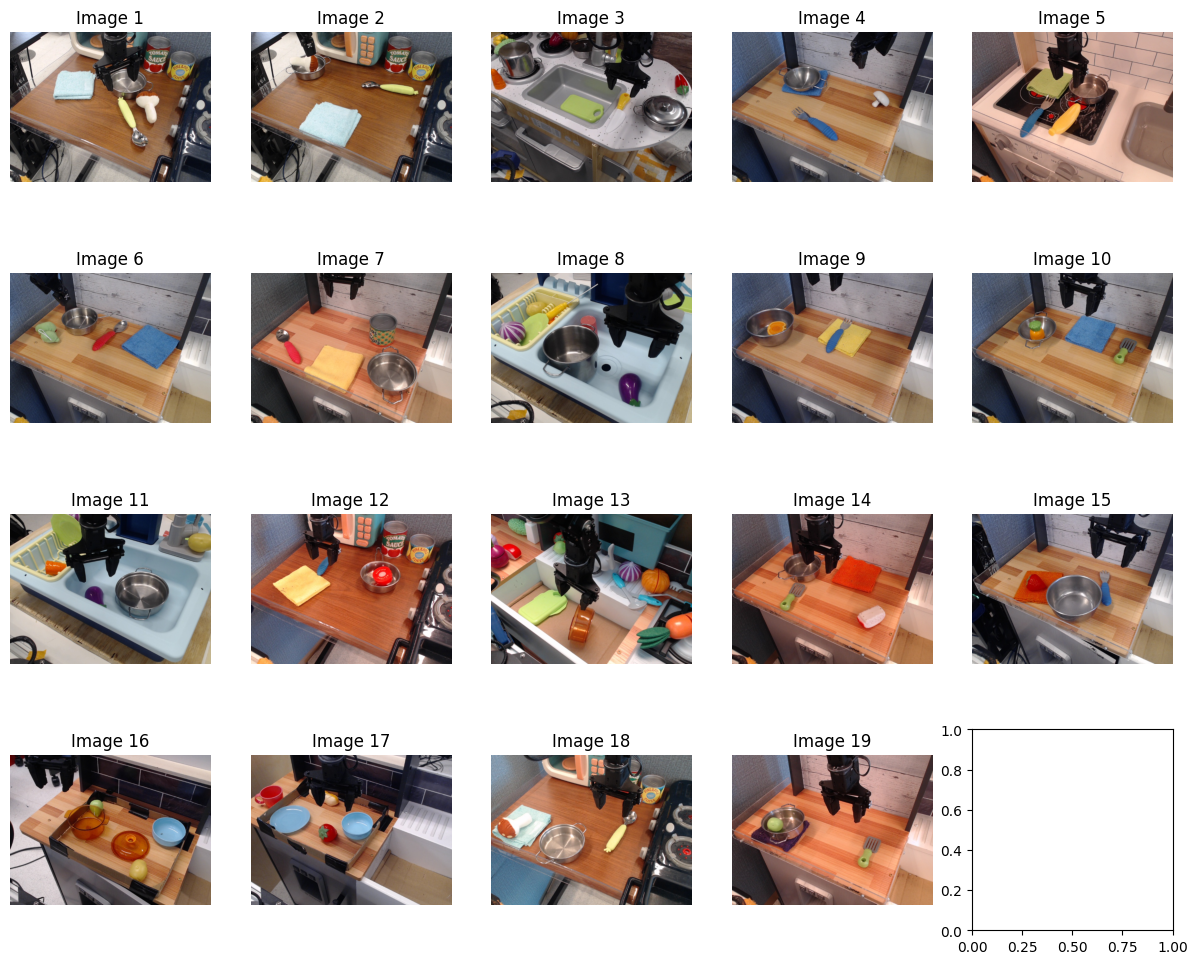

In [ ]:
ds_all = builder.as_dataset(split='train[1:20]')
images = []

for epi in ds_all:
  epi
  steps = epi[rlds.STEPS]
  for step in steps:
    im = Image.fromarray(np.array(step['observation']['image']))
    images.append(im)
    break
  '''
  clear_output(wait=True)
  display(Image(epi[observation['image']]))
  time.sleep(1)
  '''
#display.Image(as_gif(images))
import matplotlib.pyplot as plt
import numpy as np

# Create a 4x5 subplot
fig, axes = plt.subplots(4, 5, figsize=(15, 12))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot each image
for i, ax in enumerate(axes):
    ax.imshow(images[i], cmap='viridis')
    ax.axis('off')  # Turn off axis labels
    ax.set_title(f'Image {i+1}')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()


IndexError: list index out of range

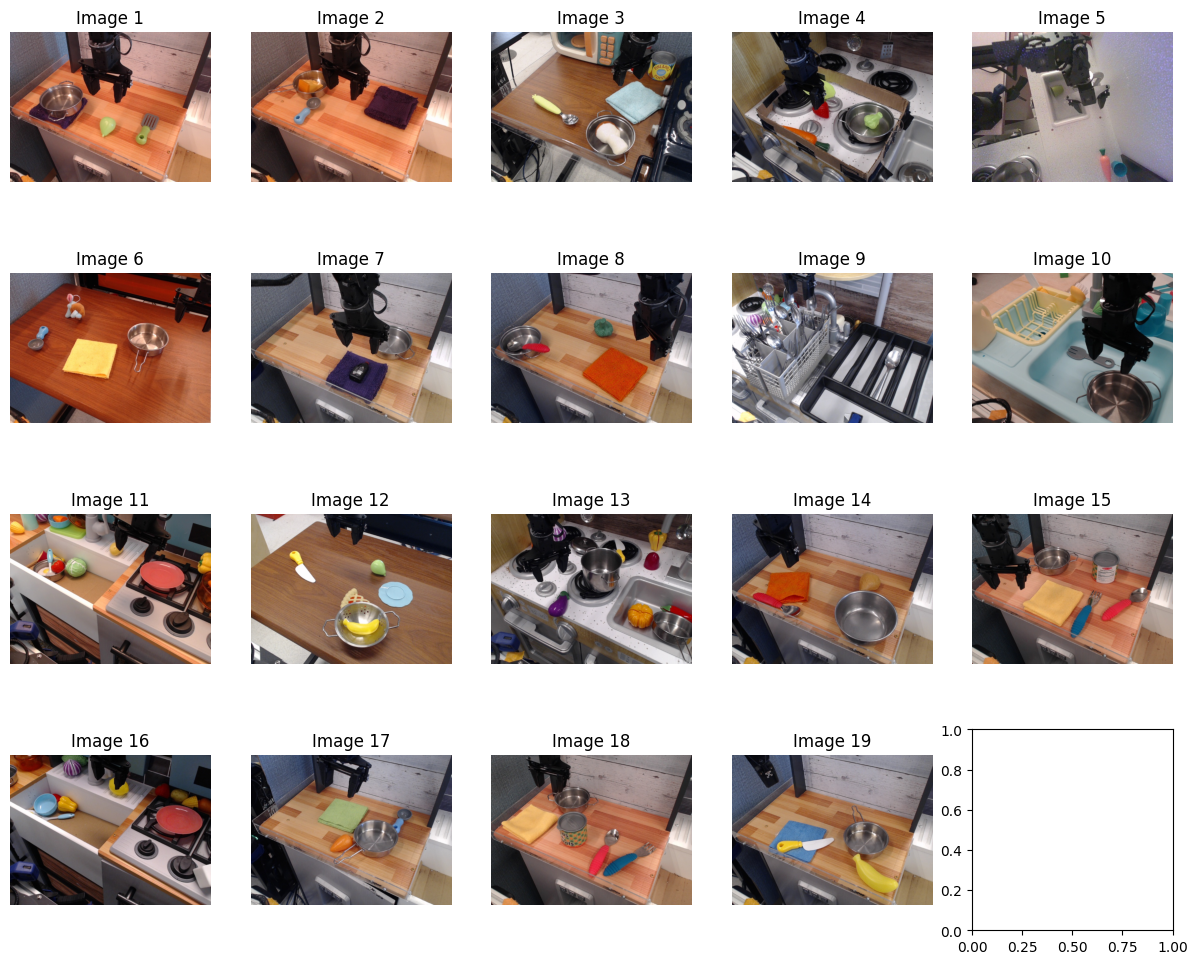

In [ ]:
ds_all = builder.as_dataset(split='test[1:20]')
images = []

for epi in ds_all:
  epi
  steps = epi[rlds.STEPS]
  for step in steps:
    im = Image.fromarray(np.array(step['observation']['image']))
    images.append(im)
    break

#display.Image(as_gif(images))
import matplotlib.pyplot as plt
import numpy as np

# Create a 4x5 subplot
fig, axes = plt.subplots(4, 5, figsize=(15, 12))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot each image
for i, ax in enumerate(axes):
    ax.imshow(images[i], cmap='viridis')
    ax.axis('off')  # Turn off axis labels
    ax.set_title(f'Image {i+1}')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()


# Dump test set image and instruction

In [ ]:
!mkdir -p bridge/test
# save instructions in instructions.txt
#   1 'put a in b'
# save image in 00000.jpg
ds_all = builder.as_dataset(split='test')
ins_fname = 'bridge/test/instructions.txt'
for i, epi in enumerate(ds_all):
  epi
  steps = epi[rlds.STEPS]
  for step in steps:
    im = Image.fromarray(np.array(step['observation']['image']))
    im.save(f'bridge/test/{i:05d}.jpg')
    instruction = step['observation']['natural_language_instruction'].numpy().decode()
    with open(ins_fname, 'a') as f:
      f.write(f'{i}, {instruction}\n')
    break


In [ ]:
!zip -r bridge.zip bridge

  adding: bridge/ (stored 0%)
  adding: bridge/test/ (stored 0%)
  adding: bridge/test/00355.jpg (deflated 0%)
  adding: bridge/test/00844.jpg (deflated 0%)
  adding: bridge/test/00954.jpg (deflated 1%)
  adding: bridge/test/01972.jpg (deflated 0%)
  adding: bridge/test/00894.jpg (deflated 0%)
  adding: bridge/test/00904.jpg (deflated 0%)
  adding: bridge/test/00728.jpg (deflated 0%)
  adding: bridge/test/02020.jpg (deflated 0%)
  adding: bridge/test/01656.jpg (deflated 0%)
  adding: bridge/test/02670.jpg (deflated 0%)
  adding: bridge/test/00374.jpg (deflated 0%)
  adding: bridge/test/01644.jpg (deflated 0%)
  adding: bridge/test/01459.jpg (deflated 0%)
  adding: bridge/test/01212.jpg (deflated 0%)
  adding: bridge/test/00342.jpg (deflated 0%)
  adding: bridge/test/02442.jpg (deflated 0%)
  adding: bridge/test/01655.jpg (deflated 0%)
  adding: bridge/test/03280.jpg (deflated 0%)
  adding: bridge/test/02131.jpg (deflated 1%)
  adding: bridge/test/02784.jpg (deflated 0%)
  adding: bridg

In [ ]:
epi[rlds.STEPS]


<_VariantDataset element_spec={'action': {'open_gripper': TensorSpec(shape=(), dtype=tf.bool, name=None), 'rotation_delta': TensorSpec(shape=(3,), dtype=tf.float32, name=None), 'terminate_episode': TensorSpec(shape=(), dtype=tf.float32, name=None), 'world_vector': TensorSpec(shape=(3,), dtype=tf.float32, name=None)}, 'is_first': TensorSpec(shape=(), dtype=tf.bool, name=None), 'is_last': TensorSpec(shape=(), dtype=tf.bool, name=None), 'is_terminal': TensorSpec(shape=(), dtype=tf.bool, name=None), 'observation': {'image': TensorSpec(shape=(480, 640, 3), dtype=tf.uint8, name=None), 'natural_language_embedding': TensorSpec(shape=(512,), dtype=tf.float32, name=None), 'natural_language_instruction': TensorSpec(shape=(), dtype=tf.string, name=None), 'state': TensorSpec(shape=(7,), dtype=tf.float32, name=None)}, 'reward': TensorSpec(shape=(), dtype=tf.float32, name=None)}>

In [ ]:
# Obtain the steps from one episode from the dataset

episode = next(ds_iterator)
steps = episode[rlds.STEPS]

In [ ]:
images = []

for step in steps:

  im = Image.fromarray(np.array(step['observation']['image']))
  images.append(im)

print(f'{len(images)} images')

display.Image(as_gif(images))

AttributeError: type object 'Image' has no attribute 'fromarray'

In [ ]:
steps = list(steps)


In [ ]:
# Load language model and

embed = hub.load(
    'https://tfhub.dev/google/universal-sentence-encoder-large/5')

In [ ]:
# embed the task string

episode_natural_language_instruction = steps[0][rlds.OBSERVATION]['natural_language_instruction'].numpy().decode()

def normalize_task_name(task_name):

  replaced = task_name.replace('_', ' ').replace('1f', ' ').replace(
      '4f', ' ').replace('-', ' ').replace('50',
                                           ' ').replace('55',
                                                        ' ').replace('56', ' ')
  return replaced.lstrip(' ').rstrip(' ')


natural_language_embedding = embed([normalize_task_name(episode_natural_language_instruction)])[0]

In [ ]:
episode_natural_language_instruction

'Place the can to the left of the pot.'

In [ ]:
episode_natural_language_instruction = 'Place the apple in the silver pan.'
natural_language_embedding = embed([normalize_task_name(episode_natural_language_instruction)])[0]


In [ ]:
steps[0][rlds.OBSERVATION]['natural_language_instruction'].numpy()

b'Place the can to the left of the pot.'

In [ ]:
steps[0][rlds.OBSERVATION]['natural_language_instruction'] = tf.constant(episode_natural_language_instruction)
steps[0][rlds.OBSERVATION]['natural_language_instruction']
natural_language_embedding = embed([normalize_task_name('Place the eggplant to the right of the pot.')])[0]

In [ ]:
step[rlds.OBSERVATION]

{'image': <tf.Tensor: shape=(480, 640, 3), dtype=uint8, numpy=
 array([[[ 86,  87,  92],
         [ 98,  99, 104],
         [ 95,  98, 103],
         ...,
         [118, 112, 112],
         [105,  95,  96],
         [ 58,  48,  49]],
 
        [[101, 102, 107],
         [110, 113, 118],
         [ 87,  90,  95],
         ...,
         [119, 110, 111],
         [ 87,  78,  79],
         [ 50,  40,  41]],
 
        [[113, 117, 120],
         [100, 104, 107],
         [ 82,  85,  90],
         ...,
         [115, 106, 109],
         [ 71,  62,  65],
         [ 46,  37,  40]],
 
        ...,
 
        [[142, 151, 146],
         [102, 111, 106],
         [ 67,  72,  68],
         ...,
         [165, 128,  99],
         [165, 128, 101],
         [166, 129, 102]],
 
        [[169, 180, 172],
         [141, 151, 143],
         [106, 111, 107],
         ...,
         [165, 128, 101],
         [164, 127, 101],
         [164, 127, 101]],
 
        [[189, 200, 192],
         [171, 181, 173],
     

In [ ]:
# %%time

policy_state = tfa_policy.get_initial_state(batch_size=1)

gt_actions = []
predicted_actions = []
images = []

for step in steps:

  image = resize(step[rlds.OBSERVATION]['image'])

  images.append(image)
  #observation['image'] = image
  observation['natural_language_embedding'] = natural_language_embedding

  tfa_time_step = ts.transition(observation, reward=np.zeros((), dtype=np.float32))

  policy_step = tfa_policy.action(tfa_time_step, policy_state)
  action = policy_step.action
  policy_state = policy_step.state

  predicted_actions.append(action)
  gt_actions.append(to_model_action(step))

In [ ]:
action_name_to_values_over_time = defaultdict(list)
predicted_action_name_to_values_over_time = defaultdict(list)
figure_layout = ['terminate_episode_0', 'terminate_episode_1',
        'terminate_episode_2', 'world_vector_0', 'world_vector_1',
        'world_vector_2', 'rotation_delta_0', 'rotation_delta_1',
        'rotation_delta_2', 'gripper_closedness_action_0']
action_order = ['terminate_episode', 'world_vector', 'rotation_delta', 'gripper_closedness_action']

for i, action in enumerate(gt_actions):

  for action_name in action_order:

    for action_sub_dimension in range(action[action_name].shape[0]):

      # print(action_name, action_sub_dimension)
      title = f'{action_name}_{action_sub_dimension}'

      action_name_to_values_over_time[title].append(action[action_name][action_sub_dimension])
      predicted_action_name_to_values_over_time[title].append(predicted_actions[i][action_name][action_sub_dimension])

In [ ]:
figure_layout = [
    ['image'] * len(figure_layout),
    figure_layout
]


InvalidArgumentError: cannot compute AddV2 as input #1(zero-based) was expected to be a int32 tensor but is a float tensor [Op:AddV2] name: 

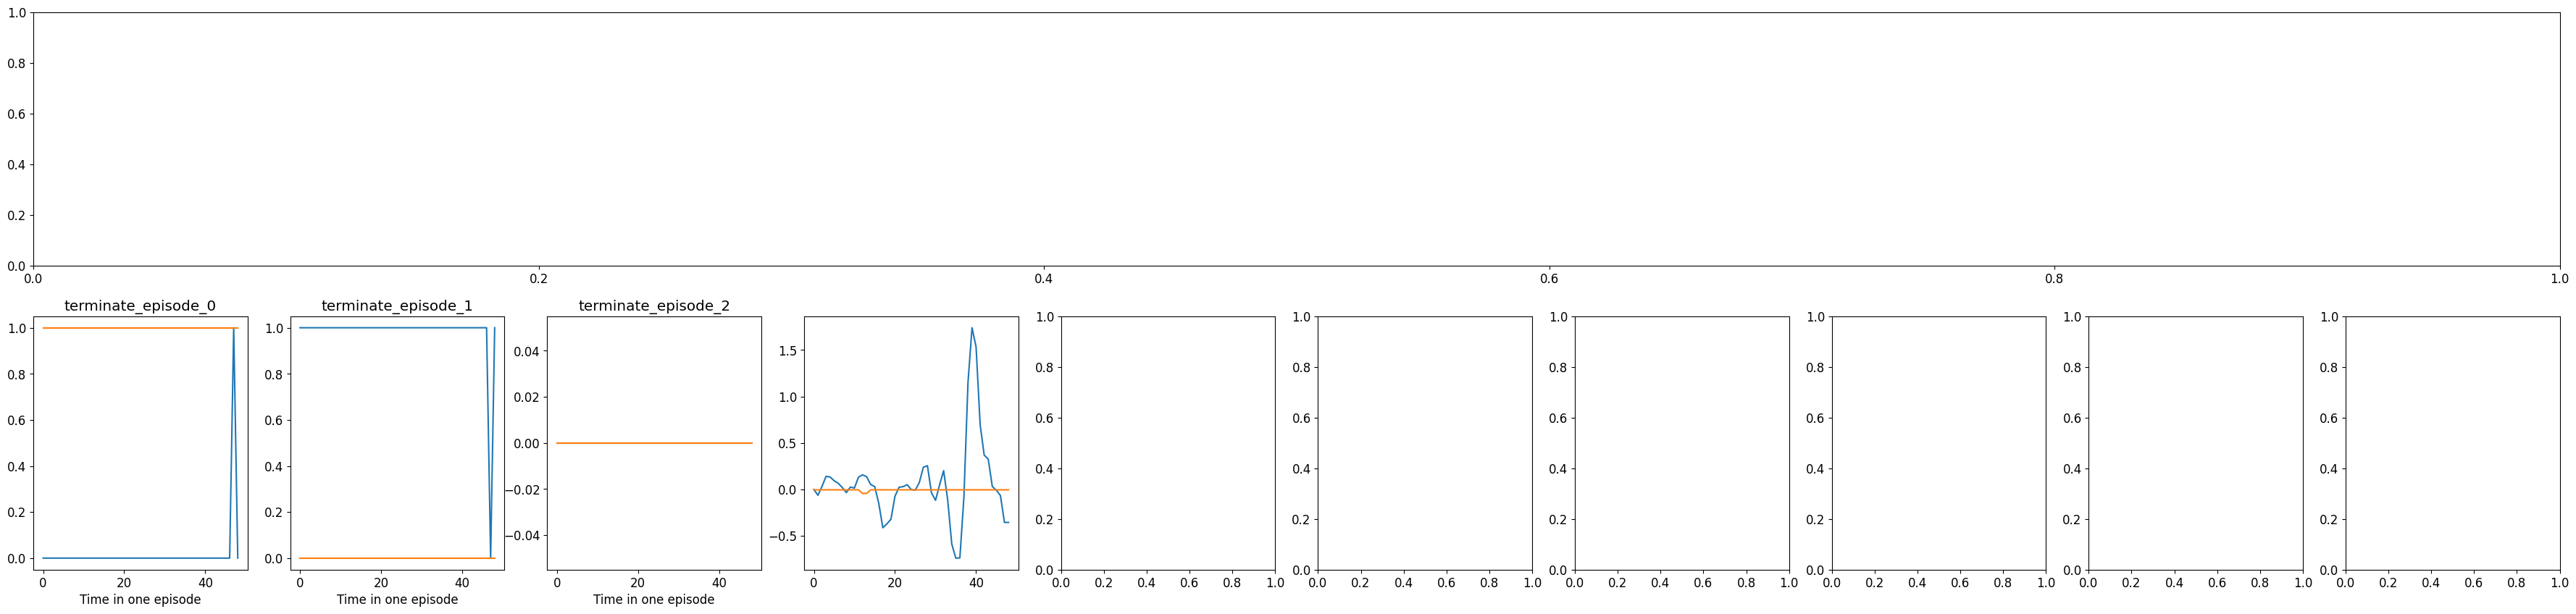

In [ ]:
MSE = 0
ts = 0
plt.rcParams.update({'font.size': 12})

stacked = tf.concat(tf.unstack(images[::3], axis=0), 1)

fig, axs = plt.subplot_mosaic(figure_layout)
fig.set_size_inches([45, 10])

for i, (k, v) in enumerate(action_name_to_values_over_time.items()):

  axs[k].plot(v, label='ground truth')
  axs[k].plot(predicted_action_name_to_values_over_time[k], label='predicted action')
  for x,y in zip(v, predicted_action_name_to_values_over_time[k]):
    #print(f'x={x}')
    #print(f'y={y}')
    MSE += (x-y) * (x-y)
    ts += 1

  axs[k].set_title(k)
  axs[k].set_xlabel('Time in one episode')

MSE /= ts

axs['image'].imshow(stacked.numpy())
axs['image'].set_xlabel('Time in one episode (subsampled)')

plt.legend()
